In [1]:
import re
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_style("ticks")


In [2]:
df = pd.read_csv('../data/metadata_with_tag.csv',
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str})

In [3]:
df_covid = df[df.tag_disease_covid19]

# Preprocessing

In [4]:
df['authors_list'] = df.authors.str.split(";")

In [5]:
author_papers = df.explode('authors_list')[['authors_list','sha']]
author_papers.columns = ['author_name','sha']
author_papers = author_papers.dropna()

In [6]:
author_papers.head(10)

,author_name,sha
0,"Madani, Tariq A",d1aafb70c066a2068b02786f8929fd9c900897fb
0,"Al-Ghamdi, Aisha A",d1aafb70c066a2068b02786f8929fd9c900897fb
1,"Vliet, Albert van der",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Eiserich, Jason P",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Cross, Carroll E",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,"Crouch, Erika C",06ced00a5fc04215949aa72528f2eeaae1d58927
3,"Fagan, Karen A",348055649b6b8cf2b9a376498df9bf41f7123605
3,"McMurtry, Ivan F",348055649b6b8cf2b9a376498df9bf41f7123605
3,"Rodman, David M",348055649b6b8cf2b9a376498df9bf41f7123605
4,"Domachowske, Joseph B",5f48792a5fa08bed9f56016f4981ae2ca6031b32


## Generalize Names

In [7]:
author_papers['author_name'] = author_papers['author_name'].str.replace(" ", "").str.replace(".","").str.replace(',',', ')

In [8]:
from mlxtend.text import generalize_names

In [9]:
unqiue_count =[]
for letters in range(1,20,2):
    unqiue_count.append(
        len(
            author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=letters))
            .unique()))

KeyboardInterrupt: 

In [ ]:
sns.lineplot(list( range(1,20,2)), unqiue_count)

In [9]:
author_papers['author_name'] = author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=5))

In [10]:
author_papers['author_name'].str.len().describe(percentiles=[.85,.9,.95,0.99,0.995,0.999,0.9995])

count     1.218020e+06
mean      1.094845e+01
std       3.585698e+00
min       0.000000e+00
50%       1.100000e+01
85%       1.400000e+01
90%       1.500000e+01
95%       1.700000e+01
99%       2.100000e+01
99.5%     2.200000e+01
99.9%     2.500000e+01
99.95%    2.600000e+01
max       9.800000e+01
Name: author_name, dtype: float64

In [11]:
author_papers = author_papers[(author_papers['author_name'].str.len() <= 25) 
                              & (author_papers['author_name'].str.len() > 0) 
                              & (author_papers['sha'] != False)
                              & (author_papers['author_name'] != 'false')]

author_papers['author_name'] = author_papers['author_name'].apply(lambda x:x.title())
author_papers.to_csv('../data/author_papers.csv',index=False)

In [13]:
covid_paper = list(df_covid.sha.unique())
covid_author_paper = author_papers[author_papers.sha.isin(covid_paper)][['author_name','sha']]

# EDA

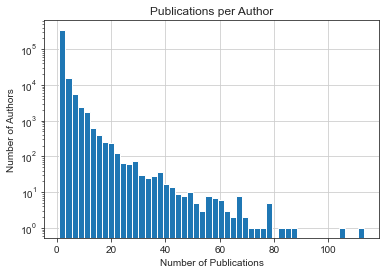

In [14]:
plt.title('Publications per Author')
plt.xlabel('Number of Publications')
plt.ylabel('Number of Authors')
covid_author_paper.groupby('author_name')['sha'].count().hist(bins=50,log=True)
plt.savefig('./pic/author_papers_hist.pdf')

In [15]:
covid_author_paper.groupby('author_name')['sha'].count().describe(percentiles=[0.75,0.9,0.95,0.99])

count    365136.000000
mean          1.701673
std           2.107762
min           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           4.000000
99%          10.000000
max         113.000000
Name: sha, dtype: float64

In [16]:
len(covid_author_paper.author_name.unique())

365136

In [17]:
author_paper_cnt = covid_author_paper.groupby('author_name')['sha'].count()
author_paper_cnt.name = 'paper_count'
filtered_author_index = author_paper_cnt[author_paper_cnt >= 3].index.to_list()
len(filtered_author_index)

48259

In [18]:
filtered_author_papers = covid_author_paper[covid_author_paper['author_name'].isin(filtered_author_index)]

In [19]:
len(filtered_author_papers)

247765

# Build Network

In [20]:
paper_dict = dict(enumerate(list(filtered_author_papers['sha'].unique())))
paper_dict = {v:k for k,v in paper_dict.items()}

In [21]:
author_dict = dict(enumerate(list(filtered_author_papers['author_name'].unique())))
author_dict = {v:k for k,v in author_dict.items()}

In [22]:
author_paper_tuple = list(zip(filtered_author_papers['author_name'], filtered_author_papers['sha']))

In [23]:
author_paper_tuple = [(author_dict[author], paper_dict[paper])for author, paper in author_paper_tuple]

In [24]:
from scipy.sparse import csc_matrix,lil_matrix

In [25]:
#AP[i,j] = 1 indicates that author i published paper j
AP = csc_matrix((np.ones(len(author_paper_tuple)), zip(*author_paper_tuple)))
##AA[i,j] = 1 indicates that author i published a paper with author j
AA = AP.dot(AP.T)

In [26]:
AA = AA.tolil()
AA.setdiag(0)

In [27]:
AA

<48259x48259 sparse matrix of type '<class 'numpy.float64'>'
	with 1305874 stored elements in List of Lists format>

In [28]:
#construct graph
G = nx.convert_matrix.from_scipy_sparse_matrix(AA)

# Network Analysis

In [29]:
degree = nx.degree(G)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=3000)

In [30]:
df_author = pd.DataFrame(author_dict.items())
df_author.columns= ['name','id']

In [31]:
df_author['degree'] = df_author['id'].apply(lambda x:degree[x])
df_author['degree_centrality'] = df_author['id'].apply(lambda x:degree_centrality[x])
df_author['eigenvector_centrality'] = df_author['id'].apply(lambda x:eigenvector_centrality[x])

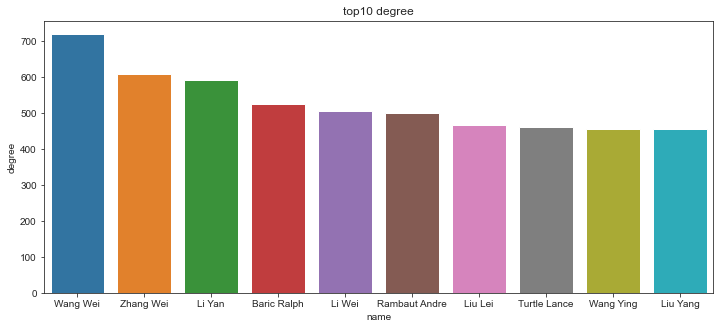

In [32]:
plt.figure(figsize=(12, 5))
plt.title('top10 degree')
sns.barplot(data=df_author.sort_values('degree',ascending=False)[:10], 
            x='name', y='degree')
plt.savefig('pic/top_10_degree.pdf')

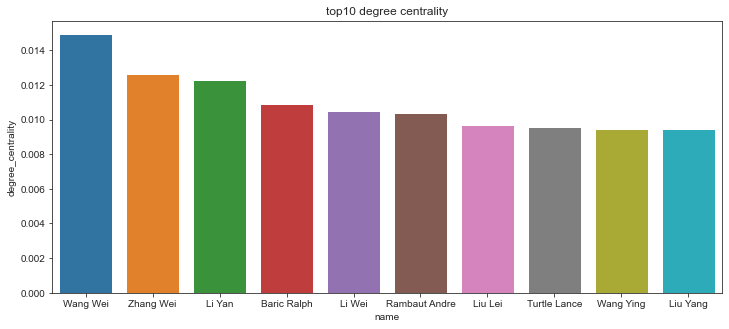

In [33]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('degree_centrality',ascending=False)[:10], 
            x='name', y='degree_centrality')
plt.savefig('pic/top_10_degree_centrality.pdf')

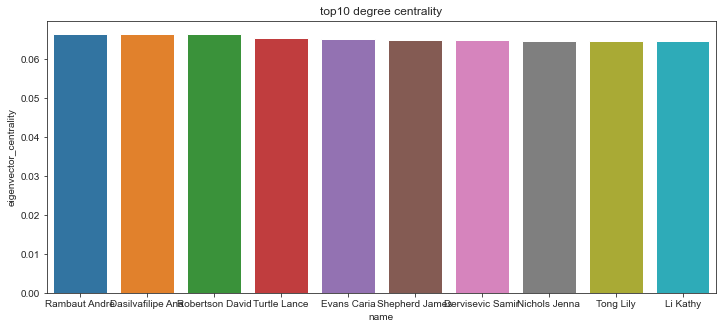

In [34]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('eigenvector_centrality',ascending=False)[:10], 
            x='name', y='eigenvector_centrality')
plt.savefig('pic/top_10_eigen_centrality.pdf')

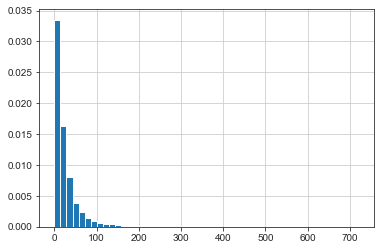

In [35]:
df_author['degree'].hist(density=True,bins=50)

# Community Detection

In [36]:
import community as community_louvain

In [37]:
partition = community_louvain.best_partition(G)

In [38]:
len(set(partition.values()))

1425

In [39]:
df_author['partition'] = df_author['id'].apply(lambda x:partition[x])

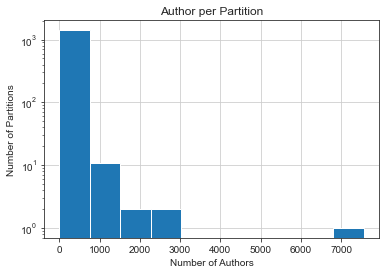

In [43]:
plt.title('Author per Partition')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Partitions')
df_author.groupby(partition)['name'].count().hist(log=True)
plt.savefig('partition_author.pdf')

In [133]:
df_author.groupby(partition)['name'].count().describe(percentiles=[0.9,0.95,0.99])

count    1423.000000
mean       33.913563
std       272.751522
min         1.000000
50%         2.000000
90%         7.000000
95%        22.900000
99%       830.400000
max      7768.000000
Name: name, dtype: float64

In [44]:
df_author = pd.merge(left=df_author, right=author_paper_cnt,how='left',left_on='name',right_on='author_name')
df_author_sampled = df_author[df_author.paper_count >= 10]
sampled_id = df_author_sampled.id.to_list()

In [47]:
df_author_sampled.groupby(partition)['id'].count().nlargest(20)

1     1087
4      191
7      177
6      174
2      130
34     116
5      109
31     107
22      97
42      84
10      83
41      78
11      72
15      72
46      71
37      67
3       65
20      58
12      57
27      53
Name: id, dtype: int64

In [48]:
top10_community = list(df_author_sampled.groupby(partition).id.count().nlargest(10).index)

In [49]:
df_author_sampled

,name,id,degree,degree_centrality,eigenvector_centrality,partition,paper_count
1,Zhang Sheng,1,214,0.004434,2.853219e-04,1,45
3,Chen Decha,3,84,0.001741,1.179889e-05,1,14
5,Wang Li,5,341,0.007066,7.677573e-05,1,45
7,Zhao Shi,7,84,0.001741,3.125579e-06,1,45
8,Cao Peihu,8,29,0.000601,7.271608e-07,1,16
...,...,...,...,...,...,...,...
43212,Shrihari Swath,43212,60,0.001243,3.101360e-04,7,10
43227,Wang Yibin,43227,107,0.002217,1.799711e-05,46,12
44147,Lin Sheng,44147,33,0.000684,9.504423e-06,73,12
44726,Benvenuto Domen,44726,15,0.000311,6.006568e-06,22,12


In [74]:
df_top_200 = df_author_sampled[
    df_author_sampled.partition.isin(top10_community)].groupby(partition).apply(
    lambda x: x.nlargest(10, 'degree_centrality'))
df_top_200 = df_top_200.reset_index()

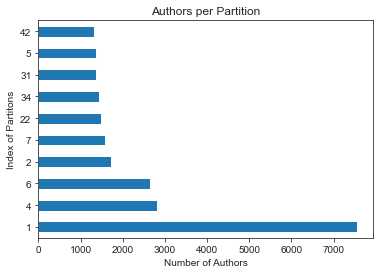

In [51]:
plt.title('Authors per Partition' )
plt.xlabel('Number of Authors')
plt.ylabel('Index of Partitons')
df_author.groupby(partition).id.count().sort_values(ascending=False)[:10].plot(kind='barh')
plt.savefig('./pic/author_per_partition.pdf')

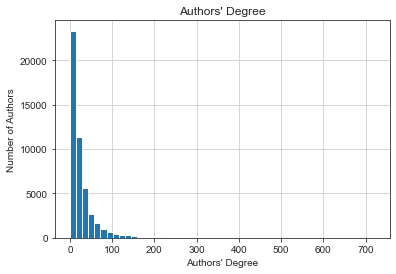

In [52]:
plt.title('Authors\' Degree' )
plt.xlabel('Authors\' Degree')
plt.ylabel('Number of Authors')
df_author['degree'].hist(bins=50)
plt.savefig('./pic/author_degree.svg')

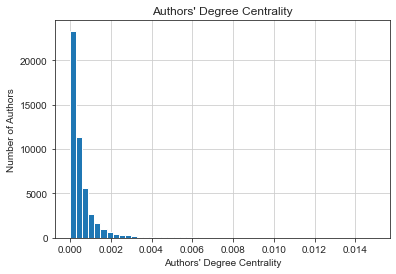

In [53]:
plt.title('Authors\' Degree Centrality' )
plt.xlabel('Authors\' Degree Centrality')
plt.ylabel('Number of Authors')
df_author['degree_centrality'].hist(bins=50)
plt.savefig('./pic/author_degree_centrality.svg')

In [54]:
modularity_dict = {}
adj_mat = nx.adjacency_matrix(G)
from sklearn.cluster import SpectralClustering
for n_clusters in np.linspace(50,500,10):
    n_clusters = int(n_clusters)
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)
    partitions_temp = sc.labels_
    partitions_temp = {i:label for i, label in enumerate(partitions_temp)}
    modularity_temp = community_louvain.modularity(partitions_temp, G)
    modularity_dict[n_clusters] = modularity_temp

KeyboardInterrupt: 

In [ ]:
plt.scatter(modularity_dict.keys(), modularity_dict.values())

In [75]:
G_visual = G.subgraph(list(map(int, list(df_top_200.id.values))))

# TODO
1. Visualization
2. Other metrics 
3. Other algorithms 
4. With paper topic model

In [76]:
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput, WheelZoomTool, NodesAndLinkedEdges, NodesOnly,Plot
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [116]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.palettes import Category10

In [117]:
df_top_200['size'] = np.round(3 * np.log2(df_top_200['degree']))
df_top_200['size'].describe()

count    100.00000
mean      23.47000
std        2.42235
min       18.00000
25%       22.00000
50%       24.00000
75%       25.00000
max       28.00000
Name: size, dtype: float64

In [118]:
node_attr = df_top_200.set_index('id')[['name','degree','paper_count','partition','size']].to_dict(orient='index')

In [119]:
nx.set_node_attributes(G_visual, node_attr)

In [120]:
SAME_PARTITION_COLOR, DIFFEREENT_PARTITION_COLOR = 'black', 'red'
edge_attrs = {}
for start_node, end_node, _ in G_visual.edges(data=True):
    edge_color = SAME_PARTITION_COLOR if G_visual.nodes[start_node]["partition"] == G_visual.nodes[end_node]["partition"] else DIFFEREENT_PARTITION_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

In [121]:
nx.set_edge_attributes(G_visual, edge_attrs, 'edge_color')

In [122]:
plot = Plot(plot_width=1200, plot_height=850,
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1))
plot.title.text = "Author Network"
node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree"), ("paper count", "@paper_count"),("partition","@partition")])
plot.add_tools(node_hover_tool,WheelZoomTool(), BoxZoomTool(), ResetTool())

In [123]:
graph_renderer = from_networkx(G_visual, nx.spring_layout, scale=10, center=(0, 0))

In [124]:
nodes_partition = [G_visual.nodes[n]['partition'] for n in G_visual.nodes()]
partition_color = {j:i for i,j in enumerate(set(nodes_partition))}
nodes_color = [partition_color[i] for i in nodes_partition]

In [126]:
graph_renderer.node_renderer.data_source.data['color'] = nodes_color
nodes_fill_color = linear_cmap('color', Category10[10], min(nodes_color), max(nodes_color))
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color=nodes_fill_color)
graph_renderer.node_renderer.selection_glyph = Circle(size='size', fill_color='white', line_width=2)
graph_renderer.node_renderer.hover_glyph = Circle(size='size', fill_color='white', line_width=2)

In [127]:
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.1, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color='black',line_alpha=0.3, line_width=2)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color='black',line_alpha=0.3, line_width=2)
graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = NodesAndLinkedEdges()

In [129]:
plot.renderers.append(graph_renderer)
output_file("author_top10community_top10_author.html")
show(plot)

{'field': 'color', 'transform': LinearColorMapper(id='7016', ...)}